In [ ]:
## trying to get scvi to work
# curl -L -O https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-MacOSX-arm64.sh
# bash Miniforge3-MacOSX-arm64.sh

# conda create -n scvi-arm python=3.12
# conda activate scvi-arm

# conda install -c conda-forge scanpy scvi-tools
# open command palette: cmd-p
# select Python interpreter: scvi-arm

In [2]:
# !pip install scanpy

In [1]:
import scanpy as sc

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
adata = sc.read_csv("../data/GSM5226574_C51ctr_raw_counts.csv.gz").T
adata

AnnData object with n_obs × n_vars = 6099 × 34546

In [3]:
# View components
# adata.obs <- dataframe of cells
# adata.var <- dataframe of genes 
# adata.X <- numpy array of counts
# adata.shape <- (cells, genes)

# Pre-processing

## Doublet removal
This step is optional but recommended because sometimes two or more cells can end up in the same droplet during scRNA-seq. \
You shouldn't do this on an integrated matrix of all samples, bur rather you do this on individual samples first and then integrate them.

In [4]:
# !pip install scvi-tools

In [5]:
import scvi

/Users/ruhi/Downloads/miniconda3/envs/scvi-arm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
adata

AnnData object with n_obs × n_vars = 6099 × 34546

In [7]:
# Only keep genes which are expressed in at least 10 cells
sc.pp.filter_genes(adata, min_cells = 10)

In [8]:
adata

AnnData object with n_obs × n_vars = 6099 × 19896
    var: 'n_cells'

In [ ]:
# !pip install scikit-misc

  Using cached scikit_misc-0.5.1-cp312-cp312-macosx_10_13_x86_64.whl.metadata (5.0 kB)
Using cached scikit_misc-0.5.1-cp312-cp312-macosx_10_13_x86_64.whl (170 kB)


In [11]:
# Only keep the top 2000 most variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True, flavor="seurat_v3")

In [12]:
adata

AnnData object with n_obs × n_vars = 6099 × 2000
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [13]:
# Set up an scvi model that can predict the doublets
# Note: This cell takes some time to run, especially if you don't have a GPU
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ruhi/Downloads/miniconda3/envs/scvi-arm/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [22:02<00:00,  1.38s/it, v_num=1, train_loss_step=319, train_loss_epoch=322]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [22:02<00:00,  3.31s/it, v_num=1, train_loss_step=319, train_loss_epoch=322]


In [14]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ruhi/Downloads/miniconda3/envs/scvi-arm/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/ruhi/Downloads/miniconda3/envs/scvi-arm/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 328/400:  82%|████████▏ | 328/400 [01:28<00:19,  3.70it/s, v_num=1, train_loss_step=0.256, train_loss_epoch=0.292]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.283. Signaling Trainer to stop.


In [18]:
# Displays probabilities of being a singlet/doublet (higher --> more likely)
df = solo.predict()
# Adds a column with the predicted labels
df['prediction'] = solo.predict(soft = False)
df

/Users/ruhi/Downloads/miniconda3/envs/scvi-arm/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/ruhi/Downloads/miniconda3/envs/scvi-arm/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


,doublet,singlet,prediction
TAGGTACCATGGCCAC-1_1,0.833565,0.166435,doublet
ATTCACTGTAACAGGC-1_1,0.817652,0.182348,doublet
TAACTTCCAACCACGC-1_1,0.759934,0.240066,doublet
TTGGGTACACGACAAG-1_1,0.768899,0.231101,doublet
AGGCCACAGAGTCACG-1_1,0.753801,0.246199,doublet
...,...,...,...
CGCCATTGTTTGCCGG-1_1,0.216885,0.783115,singlet
CACTGGGGTCTACGTA-1_1,0.000541,0.999459,singlet
CATACTTGTAGAGGAA-1_1,0.009408,0.990592,singlet
TTTGGTTTCCACGGAC-1_1,0.000498,0.999502,singlet


In [19]:
# # Removes last two characters from the index (which scvi added to the barcodes)
# # Note: This was not done in my case since scvi did not add any characters to my barcodes
# df.index = df.index.map(lambda x: x[:-2])
# df

In [ ]:
df.groupby("prediction").count()
# This tells us that around 1240 cells are predicted to be doublets, which is around 20% of our dataset
# However, some of the predicted probability differences between doublets and singlets are very low,
# so we can reconsider whether we want to throw out all of the doublet-predicted cells, or make a more informed decision

,doublet,singlet
prediction,,
doublet,1243,1243
singlet,4856,4856


In [25]:
df["difference"] = df["doublet"] - df["singlet"]
df

,doublet,singlet,prediction,difference
TAGGTACCATGGCCAC-1_1,0.833565,0.166435,doublet,0.667129
ATTCACTGTAACAGGC-1_1,0.817652,0.182348,doublet,0.635303
TAACTTCCAACCACGC-1_1,0.759934,0.240066,doublet,0.519868
TTGGGTACACGACAAG-1_1,0.768899,0.231101,doublet,0.537798
AGGCCACAGAGTCACG-1_1,0.753801,0.246199,doublet,0.507603
...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,0.216885,0.783115,singlet,-0.566230
CACTGGGGTCTACGTA-1_1,0.000541,0.999459,singlet,-0.998918
CATACTTGTAGAGGAA-1_1,0.009408,0.990592,singlet,-0.981183
TTTGGTTTCCACGGAC-1_1,0.000498,0.999502,singlet,-0.999004


In [22]:
import seaborn as sns

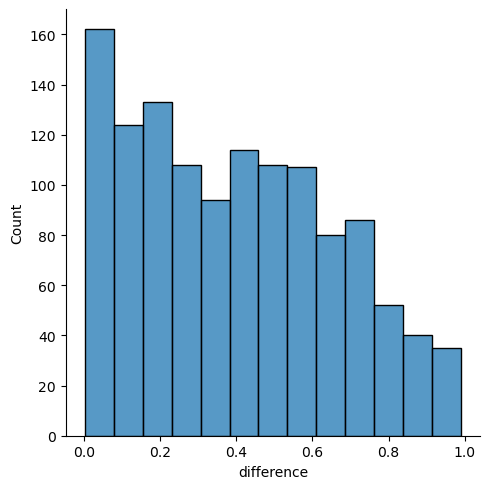

In [28]:
sns.displot(df[df.prediction == 'doublet'], x = 'difference')

In [ ]:
# A difference above 0.1 was chosen arbitrarily based on the sns distribution
doublets = df[(df.prediction == 'doublet') & (df.difference > 0.1)]
doublets

,doublet,singlet,prediction,difference
TAGGTACCATGGCCAC-1_1,0.833565,0.166435,doublet,0.667129
ATTCACTGTAACAGGC-1_1,0.817652,0.182348,doublet,0.635303
TAACTTCCAACCACGC-1_1,0.759934,0.240066,doublet,0.519868
TTGGGTACACGACAAG-1_1,0.768899,0.231101,doublet,0.537798
AGGCCACAGAGTCACG-1_1,0.753801,0.246199,doublet,0.507603
...,...,...,...,...
ACCTGAAGTGGCTGAA-1_1,0.567181,0.432819,doublet,0.134361
GGAGGTAGTTAAGCAA-1_1,0.610602,0.389398,doublet,0.221203
CGGGCATCATGGCTGC-1_1,0.633712,0.366288,doublet,0.267424
GACTCAAGTTGTCCCT-1_1,0.637190,0.362810,doublet,0.274379


In [32]:
adata

AnnData object with n_obs × n_vars = 6099 × 2000
    obs: '_scvi_batch', '_scvi_labels'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid'

In [33]:
adata = sc.read_csv("../data/GSM5226574_C51ctr_raw_counts.csv.gz").T
adata

AnnData object with n_obs × n_vars = 6099 × 34546

In [37]:
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
adata.obs

,doublet
TAGGTACCATGGCCAC-1_1,True
ATTCACTGTAACAGGC-1_1,True
TAACTTCCAACCACGC-1_1,True
TTGGGTACACGACAAG-1_1,True
AGGCCACAGAGTCACG-1_1,True
...,...
CGCCATTGTTTGCCGG-1_1,False
CACTGGGGTCTACGTA-1_1,False
CATACTTGTAGAGGAA-1_1,False
TTTGGTTTCCACGGAC-1_1,False


In [38]:
adata = adata[~adata.obs.doublet]
# The tilde means False i.e. this keeps all cells that are not doublets
adata

View of AnnData object with n_obs × n_vars = 5058 × 34546
    obs: 'doublet'

## Annotation, Visualization, Outlier Filtering

In [42]:
# Display mitochondrial genes, which in humans almost always start with capital "MT-" (can differ for other species)
adata.var[adata.var.index.str.startswith("MT-")]

,mt
MT-ND1,True
MT-ND2,True
MT-CO1,True
MT-CO2,True
MT-ATP8,True
MT-ATP6,True
MT-CO3,True
MT-ND3,True
MT-ND4L,True
MT-ND4,True


In [43]:
adata.var['mt'] = adata.var.index.str.startswith("MT-")
adata.var

,mt
AL627309.1,False
AL627309.5,False
AL627309.4,False
AL669831.2,False
LINC01409,False
...,...
VN1R2,False
AL031676.1,False
SMIM34A,False
AL050402.1,False


In [46]:
import pandas as pd

In [ ]:
# Database of 88 ribosomal genes
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"

In [47]:
ribo_genes = pd.read_table(ribo_url, skiprows=2, header=None)
ribo_genes

,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L
...,...
83,RPS9
84,RPSA
85,RSL24D1
86,RSL24D1P11


In [48]:
ribo_genes[0].values

array(['FAU', 'MRPL13', 'RPL10', 'RPL10A', 'RPL10L', 'RPL11', 'RPL12',
       'RPL13', 'RPL13A', 'RPL14', 'RPL15', 'RPL17', 'RPL18', 'RPL18A',
       'RPL19', 'RPL21', 'RPL22', 'RPL22L1', 'RPL23', 'RPL23A', 'RPL24',
       'RPL26', 'RPL26L1', 'RPL27', 'RPL27A', 'RPL28', 'RPL29', 'RPL3',
       'RPL30', 'RPL31', 'RPL32', 'RPL34', 'RPL35', 'RPL35A', 'RPL36',
       'RPL36A', 'RPL36AL', 'RPL37', 'RPL37A', 'RPL38', 'RPL39', 'RPL3L',
       'RPL4', 'RPL41', 'RPL5', 'RPL6', 'RPL7', 'RPL7A', 'RPL8', 'RPL9',
       'RPLP0', 'RPLP1', 'RPLP2', 'RPS10', 'RPS11', 'RPS12', 'RPS13',
       'RPS15', 'RPS15A', 'RPS16', 'RPS17', 'RPS18', 'RPS19', 'RPS2',
       'RPS20', 'RPS21', 'RPS23', 'RPS24', 'RPS25', 'RPS26', 'RPS27',
       'RPS27A', 'RPS27L', 'RPS28', 'RPS29', 'RPS3', 'RPS3A', 'RPS4X',
       'RPS4Y1', 'RPS5', 'RPS6', 'RPS7', 'RPS8', 'RPS9', 'RPSA',
       'RSL24D1', 'RSL24D1P11', 'UBA52'], dtype=object)

In [49]:
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
adata.var

,mt,ribo
AL627309.1,False,False
AL627309.5,False,False
AL627309.4,False,False
AL669831.2,False,False
LINC01409,False,False
...,...,...
VN1R2,False,False
AL031676.1,False,False
SMIM34A,False,False
AL050402.1,False,False


In [ ]:
#QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
adata.var
# We see additional columns now, including a column that tells us how many cells each gene was in

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL627309.1,False,False,5,0.000989,99.901147,5.0
AL627309.5,False,False,18,0.003559,99.644128,18.0
AL627309.4,False,False,2,0.000395,99.960459,2.0
AL669831.2,False,False,2,0.000395,99.960459,2.0
LINC01409,False,False,189,0.040530,96.263345,205.0
...,...,...,...,...,...,...
VN1R2,False,False,0,0.000000,100.000000,0.0
AL031676.1,False,False,0,0.000000,100.000000,0.0
SMIM34A,False,False,0,0.000000,100.000000,0.0
AL050402.1,False,False,0,0.000000,100.000000,0.0


In [ ]:
adata.obs
# This tells us how many mitochondrial or ribosomal reads were found in each cell
# We also learn how many genes in total were found per cell

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TTGGTTTTCCTAGCTC-1_1,False,3902,11472.0,463.0,4.035913,13.0,0.113319
TCTATCACAAGGCTTT-1_1,False,3582,8276.0,183.0,2.211213,5.0,0.060416
ATCCACCAGAGGTATT-1_1,False,3913,8286.0,191.0,2.305093,34.0,0.410331
CACTTCGCAGTACTAC-1_1,False,3244,8059.0,253.0,3.139347,14.0,0.173719
AAGAACATCGGATTAC-1_1,False,3384,7775.0,86.0,1.106109,8.0,0.102894
...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827


In [ ]:
adata.var.sort_values('n_cells_by_counts')
# You see some genes that were found in every cell, and also many genes that were found in almost none of the cells

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL445072.1,False,False,0,0.000000,100.000000,0.0
PAGE2B,False,False,0,0.000000,100.000000,0.0
FGF16,False,False,0,0.000000,100.000000,0.0
ARMCX3-AS1,False,False,0,0.000000,100.000000,0.0
TCEAL5,False,False,0,0.000000,100.000000,0.0
...,...,...,...,...,...,...
AKAP13,False,False,3555,2.550811,29.715302,12902.0
NEAT1,False,False,3613,4.442270,28.568604,22469.0
MBNL1,False,False,3644,2.462633,27.955714,12456.0
ZBTB20,False,False,3746,2.227363,25.939106,11266.0


In [55]:
# Filtering out genes that were found in less than 3 cells
sc.pp.filter_genes(adata, min_cells=3)

In [56]:
adata.var.sort_values("n_cells_by_counts")

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
AC007387.2,False,False,3,0.000791,99.940688,4.0,3
ACAP2-IT1,False,False,3,0.000593,99.940688,3.0,3
AC008170.1,False,False,3,0.000593,99.940688,3.0,3
AC131157.1,False,False,3,0.000593,99.940688,3.0,3
AC079352.1,False,False,3,0.000593,99.940688,3.0,3
...,...,...,...,...,...,...,...
AKAP13,False,False,3555,2.550811,29.715302,12902.0,3555
NEAT1,False,False,3613,4.442270,28.568604,22469.0,3613
MBNL1,False,False,3644,2.462633,27.955714,12456.0,3644
ZBTB20,False,False,3746,2.227363,25.939106,11266.0,3746


In [ ]:
adata.obs.sort_values("total_counts")
# We see that the lowest is 401, i.e. the authors likely got rid of cells with 400 or fewer genes
# If they had not, we would do something like sc.pp.filter_cells(adata, min_genes=200)

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TGGTACAGTTGGTGTT-1_1,False,323,401.0,0.0,0.000000,0.0,0.000000
GTCGTTCTCCAAGGGA-1_1,False,300,401.0,0.0,0.000000,0.0,0.000000
CTCAACCGTTTGGGAG-1_1,False,325,401.0,0.0,0.000000,0.0,0.000000
CAGGGCTTCATGCGGC-1_1,False,330,401.0,7.0,1.745636,1.0,0.249377
CGAGAAGGTGAACTAA-1_1,False,308,401.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...
AAGAACATCGGATTAC-1_1,False,3384,7775.0,86.0,1.106109,8.0,0.102894
CACTTCGCAGTACTAC-1_1,False,3244,8059.0,253.0,3.139347,14.0,0.173719
TCTATCACAAGGCTTT-1_1,False,3582,8276.0,183.0,2.211213,5.0,0.060416
ATCCACCAGAGGTATT-1_1,False,3913,8286.0,191.0,2.305093,34.0,0.410331


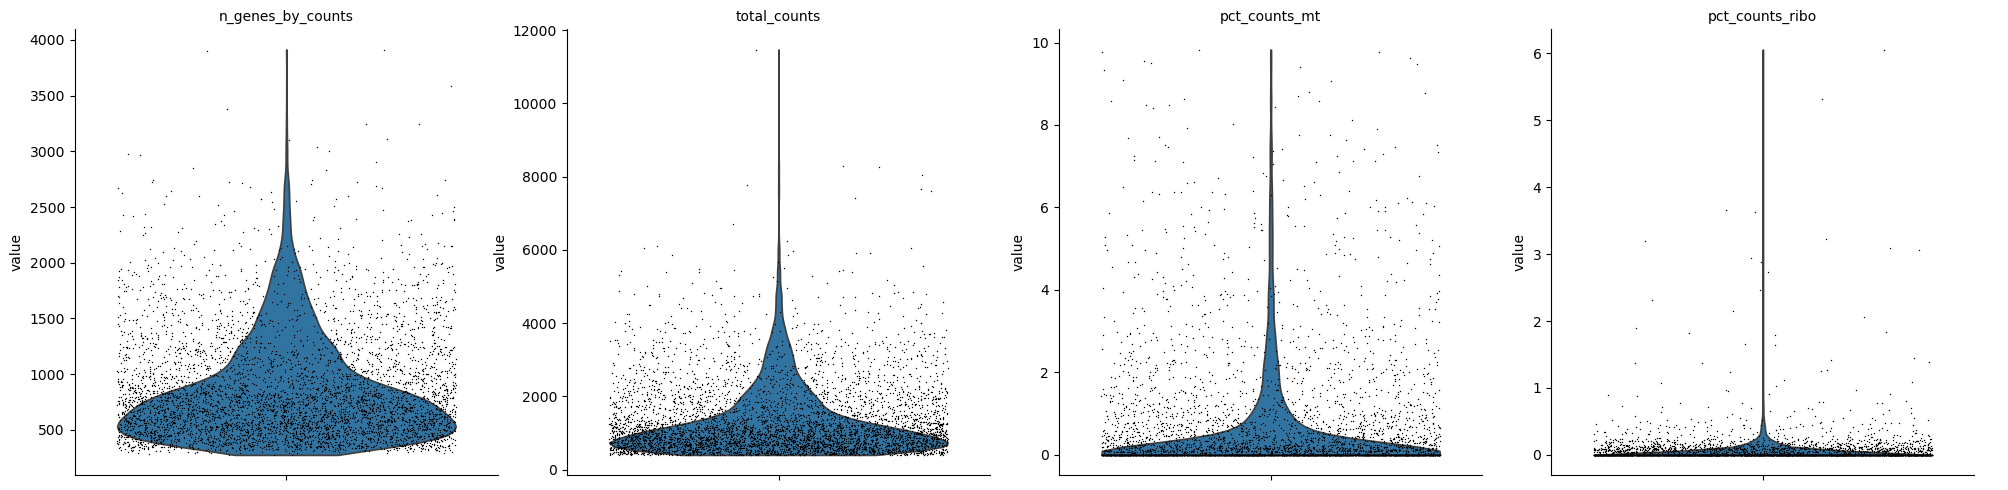

In [ ]:
# Plotting QC metrics to visualize outliers to get rid of them
# E.g. if a cell has significantly higher counts (reads) than the average, it is likely an artifact
# Similarly for total counts, although those tend to be correlated so we can filter on one
# High mitochondrial percentage count also be an artifact, or the cell could be dying
# In this case, we don't see any cells with higher than 10% mitochondrial genes, and people normally set an upper limit of 5-20%
# Similarly for ribosomal genes, most of them have close to 0% counts, with some outliers 
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True)

In [59]:
adata.obs.shape

(5058, 7)

In [60]:
import numpy as np

In [ ]:
# Using numpy to find the 98th percentile value and use that to filter

In [61]:
upper_lim = np.quantile(adata.obs.n_genes_by_counts, 0.98)
upper_lim


np.float64(2124.7199999999993)

In [63]:
adata = adata[adata.obs.n_genes_by_counts < upper_lim]
adata.obs
# So we went from 5058 cells to 4956

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
ATACTTCCAAGGTCTT-1_1,False,2122,5252.0,1.0,0.019040,4.0,0.076161
TCCGAAACAGGTACGA-1_1,False,2123,4481.0,18.0,0.401696,4.0,0.089266
TGGGCTGTCTACTTCA-1_1,False,2051,4406.0,6.0,0.136178,0.0,0.000000
GTAACCAGTCGAGTGA-1_1,False,2110,4330.0,95.0,2.193995,7.0,0.161663
CCACGTTAGGGTTAAT-1_1,False,2041,4311.0,153.0,3.549061,5.0,0.115982
...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827


In [ ]:
# We don't need to have a filter for mitochondrial gene counts, but if we did, the line of code would look something like this:
# adata = adata[adata.obs.pct_counts_mt < 20]

In [ ]:
adata = adata[adata.obs.pct_counts_ribo < 2]
adata.obs
# And now we went from 4956 to 4941 cells

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
ATACTTCCAAGGTCTT-1_1,False,2122,5252.0,1.0,0.019040,4.0,0.076161
TCCGAAACAGGTACGA-1_1,False,2123,4481.0,18.0,0.401696,4.0,0.089266
TGGGCTGTCTACTTCA-1_1,False,2051,4406.0,6.0,0.136178,0.0,0.000000
GTAACCAGTCGAGTGA-1_1,False,2110,4330.0,95.0,2.193995,7.0,0.161663
CCACGTTAGGGTTAAT-1_1,False,2041,4311.0,153.0,3.549061,5.0,0.115982
...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827


# Normalization
This step is important because there is a lot of variation among cells (including cells of the same type) in single-cell sequencing analysis, due to sequencing artifacts etc.

In [66]:
adata.X

ArrayView([[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]],
          shape=(4941, 23460), dtype=float32)

In [ ]:
adata.X.sum(axis=1)
# As you see, read counts per cell can vary from 5250 all the way down to 410

array([5250., 4474., 4405., ...,  410.,  405.,  410.],
      shape=(4941,), dtype=float32)

In [68]:
sc.pp.normalize_total(adata, target_sum=1e4)
# This normalizes the counts per cell to 10,000 reads
adata.X.sum(axis=1)

/Users/ruhi/Downloads/miniconda3/envs/scvi-arm/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


array([10000.   , 10000.   , 10000.   , ..., 10000.   , 10000.   ,
        9999.999], shape=(4941,), dtype=float32)

In [69]:
sc.pp.log1p(adata)
adata.X.sum(axis=1)

array([2858.1602, 3184.9365, 3128.7231, ..., 1191.2706, 1022.7511,
       1162.8785], shape=(4941,), dtype=float32)

In [70]:
adata.raw = adata

# Clustering